In [26]:
# Cell 1 — imports & settings
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

START = "2018-01-01"        # full-history start
END   = "2021-01-01"              # None -> today
LOOKBACK_DAYS = 252 * 3     # used for correlation filtering, backtest windows
CORR_THRESHOLD = 0.75       # quick pre-filter on returns correlation
ADF_PVALUE_THRESHOLD = 0.05 # cointegration / stationarity threshold
HALF_LIFE_MAX = 252         # max acceptable half-life (days)
MIN_TRADES = 10             # drop pairs with too few signals
N_JOBS = 4                  # parallel jobs for pair tests
ROLLING_REG_WINDOW = 252    # optional: rolling beta window for hedge ratio
OUT_OF_SAMPLE_FRACTION = 0.3  # fraction for out-of-sample testing
TRANSACTION_COST = 0.0005   # cost per trade (5 bps)


In [27]:
# Cell 2 — get ticker list (S&P 500 example)
import pandas as pd
import requests
from requests.packages.urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

session = requests.Session()
retry = Retry(total=5, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    response = session.get(url, headers=headers)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    sp500 = pd.read_html(response.text)
    tickers = sp500[0]['Symbol'].tolist()
    
    print(len(tickers))
except Exception as e:
    print(f"Error fetching data: {e}")
    # Fallback to a small sample list if the request fails
    tickers = ['AAPL','MSFT','KO','PEP','XOM','CVX','JPM','BAC','V','MA']
    print(f"Using fallback ticker list with {len(tickers)} symbols")

503


In [28]:
# Cell 3 — download adjusted close prices
def download_prices(tickers, start=START, end=END):
    data = yf.download(tickers, start=start, end=end, progress=False, threads=True)['Close']
    data = data.dropna(axis=0, how='all')  # drop rows with no data
    return data

prices = download_prices(tickers)
prices = prices.dropna(axis=1)  # drop tickers with no series
prices.shape



10 Failed downloads:
['SOLV', 'CEG', 'GEHC', 'COIN', 'GEV', 'KVUE', 'EXE', 'VLTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2021-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1609477200")')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2021-01-01)')
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


(756, 479)

In [29]:
# Cell 4 — quick correlation filter to reduce pairs
returns = prices.pct_change().dropna()
corr_window = returns.iloc[-LOOKBACK_DAYS:]
corr = corr_window.corr()

pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if corr.iloc[i,j] >= CORR_THRESHOLD:
            pairs.append((cols[i], cols[j], corr.iloc[i,j]))
len(pairs)


1055

In [30]:
# Cell 5 — helper functions (cointegration test, half-life, backtest)
def engle_granger_test(s1, s2):
    try:
        score, pvalue, _ = coint(s1, s2)
        return pvalue, score
    except Exception as e:
        return np.nan, np.nan

def ols_hedge_ratio(y, x):
    # regress y on x: y = a + b*x
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    intercept = model.params[0]
    beta = model.params[1]
    return intercept, beta, model

def compute_half_life(spread):
    # half-life via AR(1) on lagged spread
    spread_lag = spread.shift(1).dropna()
    delta = (spread - spread.shift(1)).dropna()
    # align
    spread_lag = spread_lag.loc[delta.index]
    X = sm.add_constant(spread_lag)
    res = sm.OLS(delta, X).fit()
    phi = res.params.iloc[1]
    if phi >= 0:
        return np.inf
    halflife = -np.log(2) / phi
    return halflife

def zscore(series, window=20):
    return (series - series.rolling(window).mean()) / series.rolling(window).std()

def backtest_pair(prices_df, t1, t2, beta, lookback_mean=20, z_enter=2.0, z_exit=0.5, tx_cost=TRANSACTION_COST):
    # compute spread, z-score, simple position logic on residual
    y = prices_df[t1]
    x = prices_df[t2]
    y_pred = beta * x  # assume no intercept for hedge scaling; if intercept used adjust
    spread = y - y_pred
    z = zscore(spread, window=lookback_mean).fillna(0)
    # signals: long spread when z < -z_enter (long y, short beta*x)
    long = z < -z_enter
    short = z > z_enter
    exit = z.abs() < z_exit
    # positions DataFrame (dollar neutral per unit y)
    pos_y = pd.Series(0, index=spread.index)
    pos_x = pd.Series(0, index=spread.index)
    pos_y[long] = 1
    pos_x[long] = -beta
    pos_y[short] = -1
    pos_x[short] = beta
    # exit resets
    pos_y[exit] = 0
    pos_x[exit] = 0
    pos_y = pos_y.ffill().shift(1).fillna(0)  # act on next day
    pos_x = pos_x.ffill().shift(1).fillna(0)
    returns = prices_df.pct_change().fillna(0)
    strat_rets = pos_y * returns[t1] + pos_x * returns[t2]
    # transaction cost approx: count changes in position on both legs
    trades = (pos_y.diff().abs() + pos_x.diff().abs()).fillna(0)
    costs = trades * tx_cost
    strat_rets_net = strat_rets - costs
    # metrics
    cum = (1 + strat_rets_net).cumprod()
    sharpe = np.sqrt(252) * strat_rets_net.mean() / (strat_rets_net.std() + 1e-12)
    maxdd = (cum / cum.cummax() - 1).min()
    num_trades = trades.sum()
    return {
        'sharpe': sharpe,
        'maxdd': maxdd,
        'cumret': cum.iloc[-1] - 1,
        'num_trades': num_trades,
        'series': {
            'spread': spread, 'z': z, 'strategy_returns': strat_rets_net, 'cumulative': cum
        }
    }


In [31]:
# Cell 6 — pair evaluation loop (parallel)
from math import isfinite
results = []

def evaluate_pair(pair):
    t1, t2, corr_val = pair
    s1 = prices[t1].dropna()
    s2 = prices[t2].dropna()
    
    common_idx = s1.index.intersection(s2.index)
    if len(common_idx) < 252:  # need at least 1 year
        return None
    s1 = s1.loc[common_idx]
    s2 = s2.loc[common_idx]
    # test cointegration
    pvalue, score = engle_granger_test(s1, s2)
    if np.isnan(pvalue) or pvalue > ADF_PVALUE_THRESHOLD:
        return None
    # OLS for hedge ratio (you can also use statsmodels)
    intercept, beta, model = ols_hedge_ratio(s1, s2)
    # residual spread
    spread = s1 - (intercept + beta * s2)
    # ADF test on spread
    adf_p = adfuller(spread.dropna())[1]
    if adf_p > ADF_PVALUE_THRESHOLD:
        return None
    # half-life
    hl = compute_half_life(spread.dropna())
    if not isfinite(hl) or hl <= 0 or hl > HALF_LIFE_MAX:
        return None
    # basic backtest
    bt = backtest_pair(prices, t1, t2, beta)
    if bt['num_trades'] < MIN_TRADES:
        return None
    out = {
        't1': t1, 't2': t2, 'corr': corr_val,
        'coint_p': pvalue, 'adf_p': adf_p, 'hedge_beta': beta, 'half_life': hl,
        'sharpe': bt['sharpe'], 'maxdd': bt['maxdd'], 'num_trades': bt['num_trades'],
        'cumret': bt['cumret']
    }
    return out

pairs_to_test = [(a,b,c) for (a,b,c) in pairs]  # from corr prefilter
print("Testing", len(pairs_to_test), "pairs (filtered by corr). This may take a while...")

res_list = Parallel(n_jobs=N_JOBS)(delayed(evaluate_pair)(p) for p in tqdm(pairs_to_test))
res_list = [r for r in res_list if r is not None]
results_df = pd.DataFrame(res_list).sort_values('sharpe', ascending=False).reset_index(drop=True)
results_df.to_csv("pairs_results.csv", index=False)
results_df.head(30)


Testing 1055 pairs (filtered by corr). This may take a while...


  0%|          | 0/1055 [00:00<?, ?it/s]

,t1,t2,corr,coint_p,adf_p,hedge_beta,half_life,sharpe,maxdd,num_trades,cumret
0,SWK,TEL,0.776213,0.031188,0.007705,1.491566,16.725906,1.235307,-0.083091,199.325252,0.510295
1,CFG,RF,0.933369,0.040835,0.010564,2.218625,25.301481,1.119353,-0.152275,270.364526,0.906382
2,KEY,NTRS,0.793870,0.004808,0.000907,0.248806,16.251521,1.014694,-0.102811,79.923562,0.476267
3,PEP,PG,0.758227,0.021945,0.005131,0.638778,14.712177,0.977277,-0.034929,154.045122,0.187349
4,CCI,SBAC,0.828692,0.043463,0.011412,0.380491,13.885680,0.761103,-0.066714,107.678295,0.168114
5,MA,V,0.926818,0.008018,0.001612,1.908101,9.691277,0.691128,-0.108300,238.464291,0.206113
6,AVB,EQR,0.916824,0.038991,0.009999,2.233056,19.327956,0.607749,-0.173218,258.644447,0.302695
7,DLR,EQIX,0.752100,0.011473,0.002423,0.115446,13.114464,0.596965,-0.088499,87.004785,0.183112
8,GL,JPM,0.841468,0.000029,0.000004,0.778797,9.997407,0.536040,-0.101448,156.534176,0.120477
9,D,ES,0.820777,0.001728,0.000292,0.532804,12.198604,0.515799,-0.111303,131.821137,0.133659


Top pair: SWK TEL Sharpe: 1.2353074048758281 Half-life: 16.725906380679366


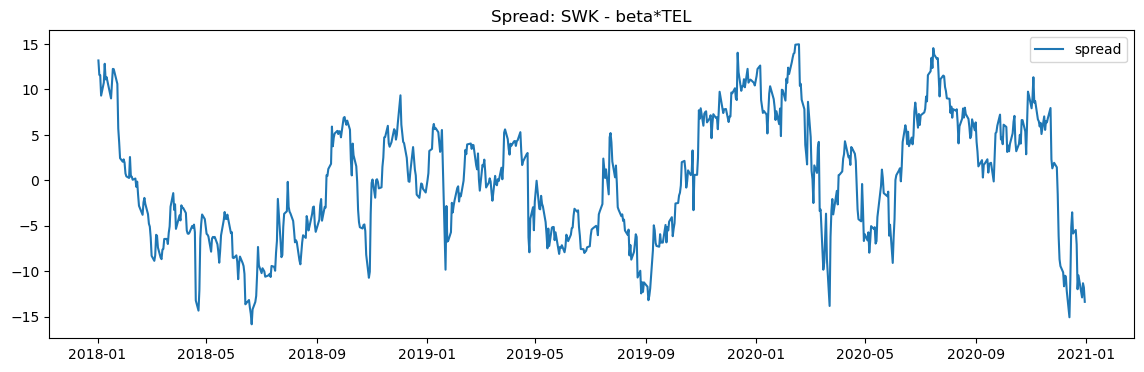

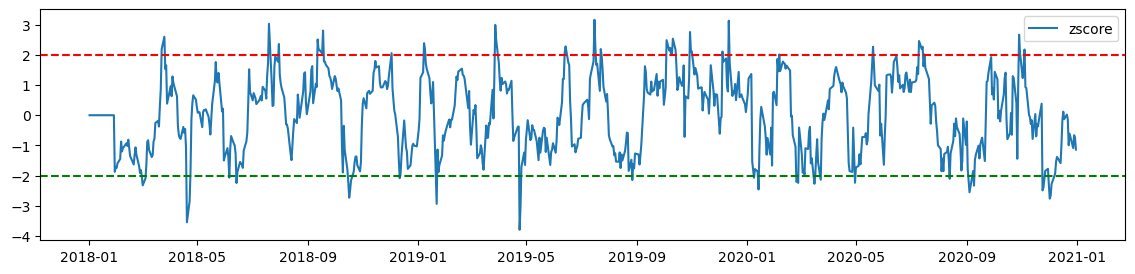

In [32]:
# Cell 7 — visualize best pair example
if not results_df.empty:
    row = results_df.iloc[0]
    t1, t2 = row['t1'], row['t2']
    print("Top pair:", t1, t2, "Sharpe:", row['sharpe'], "Half-life:", row['half_life'])
    # retrieve series from earlier function by recomputing quickly
    intercept, beta, _ = ols_hedge_ratio(prices[t1].dropna(), prices[t2].dropna())
    spread = prices[t1] - (intercept + beta * prices[t2])
    z = zscore(spread, window=20).fillna(0)
    plt.figure(figsize=(14,4))
    plt.plot(spread, label='spread'); plt.legend(); plt.title(f"Spread: {t1} - beta*{t2}")
    plt.show()
    plt.figure(figsize=(14,3))
    plt.plot(z, label='zscore'); plt.axhline(2, color='r', linestyle='--'); plt.axhline(-2,color='g',linestyle='--'); plt.legend()
    plt.show()


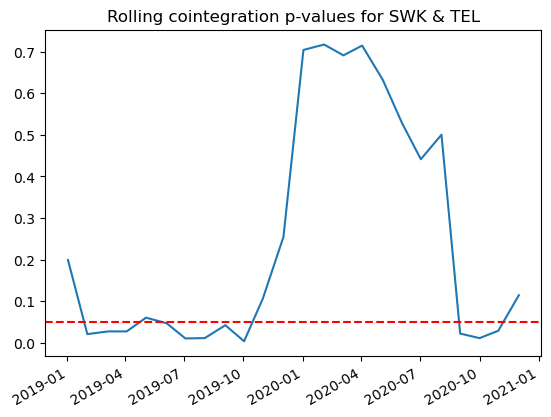

In [33]:
# Cell 8 — extra: run rolling cointegration (optional)
# This checks cointegration in rolling windows and outputs stability metrics
def rolling_cointegration(a, b, window=252, step=21):
    pvals = []
    dates = []
    for i in range(0, len(a)-window, step):
        s1 = a.iloc[i:i+window]; s2 = b.iloc[i:i+window]
        pval = coint(s1, s2)[1]
        pvals.append(pval)
        dates.append(s1.index[-1])
    return pd.Series(pvals, index=dates)

# Example of usage on top pair
if not results_df.empty:
    top = results_df.iloc[0]
    r = rolling_cointegration(prices[top['t1']], prices[top['t2']], window=252, step=21)
    r.plot(title=f"Rolling cointegration p-values for {top['t1']} & {top['t2']}"); plt.axhline(0.05,color='r',linestyle='--')
